# Feature extraction and 

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from scipy import stats

from sklearn.model_selection import train_test_split
import nibabel as nib

In [2]:
subjects = ['Sub_001','Sub_002','Sub_003','Sub_004','Sub_005','Sub_006','Sub_007','Sub_008','Sub_009','Sub_010',]
CN = ['Sub_001','Sub_003','Sub_004','Sub_005','Sub_007',]
AD = ['Sub_002','Sub_006','Sub_008','Sub_009','Sub_010',]

# Construct feature vector
---

## PCA

Suppose that there are m n-dimensional vectors.

    1.Align them to get a n x m matrix X;
    2.Normalise to zero-mean: subtract mean value from every row;
    3.Determine the covariance matrix: C = 1/mXX^T;
    4.Determine the eigenvalues and eigenvectors of C;
    5.Sort eigenvalues, align the corresponding eigenvectors from top to bottom, take the first k rows as matrix P;
    6.Y = PX is the result of dimension reduction (n -> k).

One problem with PCA is that when multiply a large-size matrix by its transpose matrix, the dimension of the product can be huge, thus exceeds memory limit.

In [4]:
# import scipy.linalg as la

In [5]:
# def PCA(X, k):
#     # X is the data, and k is the number of principle components wanted
#     # ref: https://zhuanlan.zhihu.com/p/77151308
#     single_col = False
#     try:
#         n, m = X.shape
#     except:
#         n, m = len(X), 1
#         X = X.reshape((n,m))
#         single_col = True
    
#     if single_col:
#         X = X - np.mean(X)
#     else:
#         for r in X:
#             r = r - np.mean(r)
        
#     C = 1 / m * X @ (X.T)     # C is the covariance matrix
#     results = la.eig(C)
#     eigen_vals = results[0]
#     eigen_vecs = results[1]   # eigenvector of C in columns
#     eigen_vecs = gram_schmidt_columns(eigen_vecs)   # orthogonormalization
    
#     eigen_vecs = eigen_vecs.T # eigenvector in rows, then sort by eigenvalues
#     results = np.array(sorted(zip(eigen_vals, eigen_vecs), key=lambda x:x[0], reverse = True))
    
#     eigen_vals = results[:,0]
#     ET = np.vstack(results[:,1])  # first k rows
#     P = ET              # covariance matrix
#     Y = P[0:k] @ X      # largest k eigenvalues @ original matrix
    
#     return Y
    

# #check:
# #     print('\n\n')
# #     print(eigen_vals)
# #     print(eigen_vecs)
# #     print('\n\n')
# #     print('dot product:', eigen_vecs[:,2] @ eigen_vecs[:,0])
# #     print('--',eigen_vals[1] * eigen_vecs[:,1], '\n--', C @ eigen_vecs[:,1])

# def gram_schmidt_columns(X):
#     Q, R = np.linalg.qr(X)
#     return Q

## Voxels of interest

对于每个特征，选取CN组和AD组存在显著差异的体素作为感兴趣体素。

**选取方法：**

以单个体素为中心进行区域扩展，计算其临近3x3x3体素立方（约9mmx9mmx9mm区域）的均值，将10个被试同一体素处的值构建为一序列，对CN组与AD组各5个值做假设检验。遍历64x64x48个体素，选取两组差异显著的5个体素。

将所选取的体素对应到解剖结构图（对应的nii文件）中，记录其所在的解剖区域名称。

In [3]:
HOME = r'D:\results0622\Results'

In [4]:
def show_slices_3d(img_data,x,y,z,t):
    fig,axes = plt.subplots(1, 3, figsize=(15,8))
    sl_0 = img_data[x, :, :]
    sl_1 = img_data[:, y, :]
    sl_2 = img_data[:, :, z]
    for i,sl in enumerate([sl_0, sl_1, sl_2]):
        axes[i].imshow(sl.T,cmap="gray",origin="lower")
        if i == 0:
            axes[i].scatter(y,z,color='r')
        elif i ==1:
            axes[i].scatter(x,z,color='r')
        else:
            axes[i].scatter(x,y,color='r')
    plt.suptitle(t)
    
def voi_display(feature_folder):
    ###############################################
    #         Go through all the voxels
    ###############################################

    # total number of voxels
    d_x, d_y, d_z = 61, 73, 61      # dimension of the template

    ###############################################
    #         Go through all the subjects
    ###############################################

    path = HOME + '\\' + feature_folder

    files = os.listdir(path)
    x = {}
    for f in files:
        if f.endswith('.nii') and f.startswith('z'):
            print(f)

            X = nib.load(path + '\\' + f)
            fdata = X.get_fdata()


            coordinates = []
            for i in range(1, d_x - 1):
                for j in range(1, d_y - 1):
                    for k in range(1, d_z - 1):
                        if fdata[i][j][k] != 0:
                            coordinates.append((i, j, k))

            voxels = []
            pos = []
            # local voxels: 3*3*3, approximately: 9mm*9mm*9mm
            for r in coordinates:
                grow = []
                for a in range(r[0]-1, r[0]+2):
                    for b in range(r[1]-1, r[1]+2):
                        for c in range(r[2]-1, r[2]+2):
                            grow.append((a, b, c))
                voxels.append(grow)
                pos.append((r[0], r[1], r[2]))


            sx = []
            for grow in voxels:
                n = len(grow)
                s = 0
                for g in grow:
                    s += fdata[g[0]][g[1]][g[2]]
                sx.append(s / n)        
            sx = np.array(sx)
            x[f[-11:-4]] = sx

    x['pos'] = pos

    ###############################################
    #         Display and save the dataframe
    ###############################################

    df = pd.DataFrame(x)
    df.to_csv(path + '.csv')
    print(df.head(5))

    ###############################################
    #   Select 10 voxels with lowest p-values
    ###############################################

    dif = []
    for i in range(df.shape[0]):
        p_cn = np.array([df[s][i] for s in CN])
        p_ad = np.array([df[s][i] for s in AD])
        t_stat, p = stats.ttest_ind(p_cn, p_ad, equal_var = False)
        if not math.isnan(p):
            dif.append((df['pos'][i], p))

    dif = sorted(dif, key=lambda x:x[1], reverse=False)
    voi = dif[:5]     # the 5 voxels with the lowest p-values
    print('voi:', voi)

    files = os.listdir(path)
    x = {}
    coordinates = []
    for f in files:
        if f.endswith('.nii') and f.startswith('z'):
            img_data = nib.load(path + '\\' + f).get_fdata()
            for i, xyz in enumerate(voi):
                coordinates.append(('r'+ str(i), xyz[0][0], xyz[0][1], xyz[0][2]))
                show_slices_3d(img_data, xyz[0][0], xyz[0][1], xyz[0][2], 'r'+ str(i))
            break


    data = []
    for subject in subjects:
        sample_voxels = []
        for r, x, y, z in coordinates:
            sample_voxels.append(list(df[subject][df['pos']==(x,y,z)])[0])
        data.append(sample_voxels)

    print(coordinates)

    for i, row in enumerate(data):
        feature_vectors[i].extend(row)
    
    data = np.array(data).T
    cmap = plt.cm.coolwarm
    # CN: line, Dementia: dash line
    custom_cycler = (cycler(color=cmap(np.linspace(0,1,10))) +
                      cycler(linestyle=['-', ':','-','-','-',':','-',':',':',':']))
    N = 10
    custom_legend = [Line2D([0], [0], color=cmap(.1), ls='-'),
                     Line2D([0], [0], color=cmap(.2), ls=':'),
                     Line2D([0], [0], color=cmap(.3), ls='-'),
                     Line2D([0], [0], color=cmap(.4), ls='-'),
                     Line2D([0], [0], color=cmap(.5), ls='-'),
                     Line2D([0], [0], color=cmap(.6), ls=':'),
                     Line2D([0], [0], color=cmap(.7), ls='-'),
                     Line2D([0], [0], color=cmap(.8), ls=':'),
                     Line2D([0], [0], color=cmap(.9), ls=':'),
                     Line2D([0], [0], color=cmap(1.), ls=':'),]


    cmap = plt.cm.coolwarm
    rcParams['axes.prop_cycle'] = cycler(custom_cycler)

    fig, ax = plt.subplots(figsize=(12,6))
    lines = ax.plot(data)
    xticks = list(zip(*coordinates))[0]
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.legend(custom_legend, subjects)
    fig.show()

In [5]:
feature_vectors = [[] for _ in range(10)]

### ALFF

zALFFMap_Sub_001.nii
zALFFMap_Sub_002.nii
zALFFMap_Sub_003.nii
zALFFMap_Sub_004.nii
zALFFMap_Sub_005.nii
zALFFMap_Sub_006.nii
zALFFMap_Sub_007.nii
zALFFMap_Sub_008.nii
zALFFMap_Sub_009.nii
zALFFMap_Sub_010.nii
    Sub_001   Sub_002   Sub_003   Sub_004   Sub_005   Sub_006   Sub_007  \
0  0.058383  0.120517  0.155074  0.359280  0.028457  0.485367 -0.172570   
1 -0.021027  0.221413  0.025110  0.581153  0.277370  0.726679 -0.168699   
2 -0.061326  0.160164 -0.104118  0.493122  0.539790  0.705135 -0.227336   
3  0.010425  0.007282 -0.080360  0.145660  0.558205  0.463379 -0.198281   
4 -0.013492 -0.171407 -0.133275 -0.206287  0.428810  0.289226 -0.217224   

    Sub_008   Sub_009   Sub_010          pos  
0  0.542622  0.206976  0.307993  (6, 29, 21)  
1  0.975051  0.244154  0.513716  (6, 29, 22)  
2  1.232500  0.198373  0.515206  (6, 29, 23)  
3  0.924617  0.178670  0.267898  (6, 29, 24)  
4  0.472976  0.207394  0.043060  (6, 29, 25)  
voi: [((27, 20, 18), 3.1069880290900913e-05), ((49, 38, 3

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:147: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


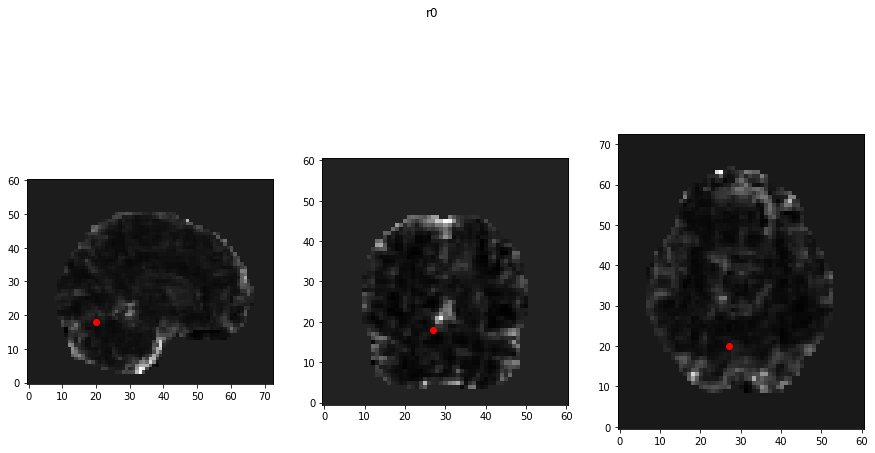

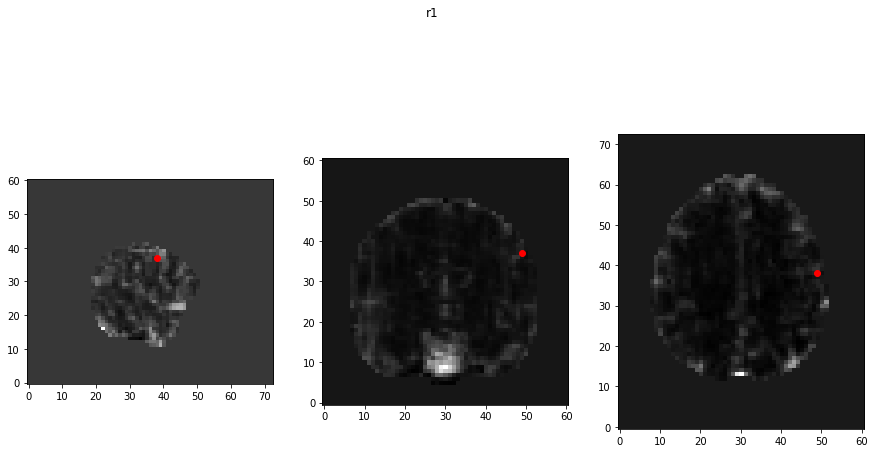

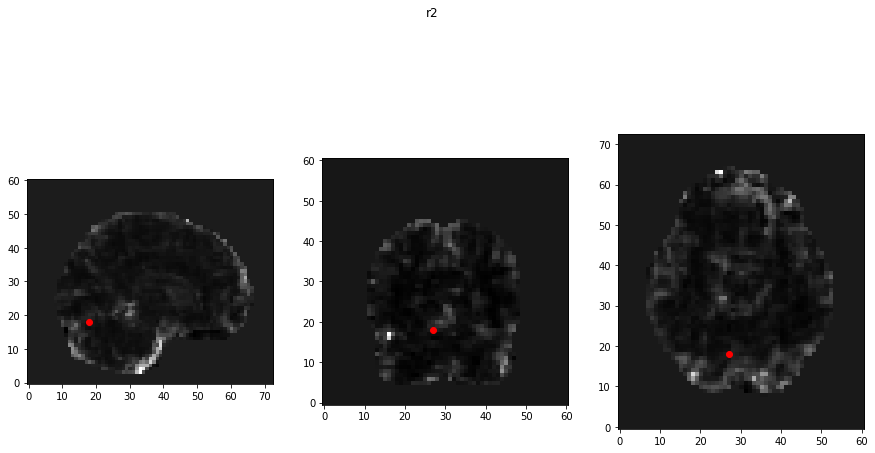

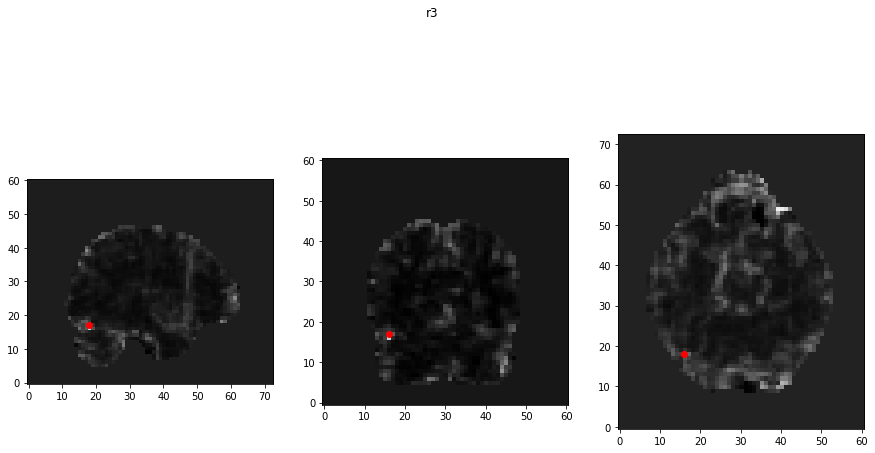

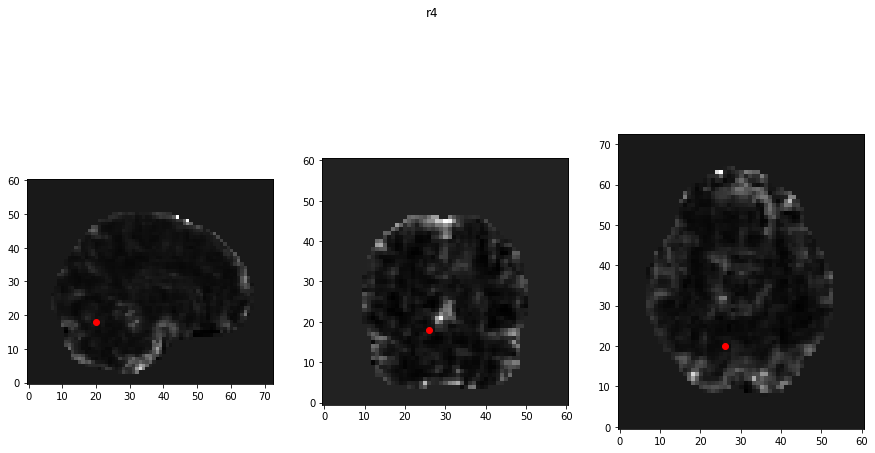

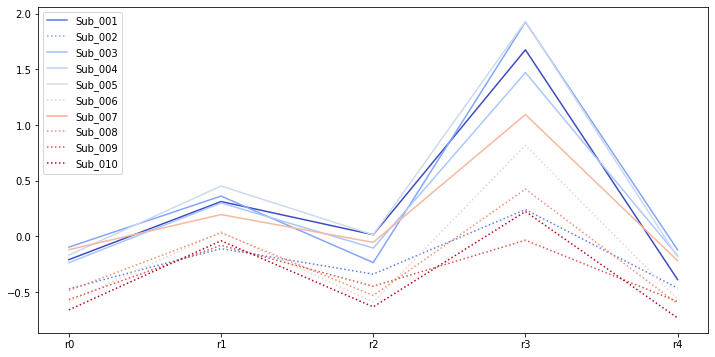

In [8]:
voi_display('ALFF_FunImgWC')

In [10]:
dif

NameError: name 'dif' is not defined

### fALFF

zfALFFMap_Sub_001.nii
zfALFFMap_Sub_002.nii
zfALFFMap_Sub_003.nii
zfALFFMap_Sub_004.nii
zfALFFMap_Sub_005.nii
zfALFFMap_Sub_006.nii
zfALFFMap_Sub_007.nii
zfALFFMap_Sub_008.nii
zfALFFMap_Sub_009.nii
zfALFFMap_Sub_010.nii
    Sub_001   Sub_002   Sub_003   Sub_004   Sub_005   Sub_006   Sub_007  \
0  0.245678  0.049490  0.166400  0.441614  0.095276  0.320728  0.193271   
1  0.009226  0.131505 -0.035322  0.441674  0.235531  0.515528  0.068917   
2 -0.089076  0.177078 -0.078003  0.293167  0.497844  0.476845 -0.106806   
3  0.095711  0.024888  0.074367  0.109300  0.609745  0.464771 -0.003870   
4  0.112927 -0.175092 -0.103411  0.067698  0.460946  0.432676  0.132825   

    Sub_008   Sub_009   Sub_010          pos  
0  0.688303  0.473087  0.415875  (6, 29, 21)  
1  0.912734  0.409402  0.655339  (6, 29, 22)  
2  0.914328  0.218418  0.807529  (6, 29, 23)  
3  0.860840  0.249354  0.517436  (6, 29, 24)  
4  0.878158  0.400481  0.058256  (6, 29, 25)  
voi: [((41, 20, 12), 8.611491495641845e-05), ((

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:147: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


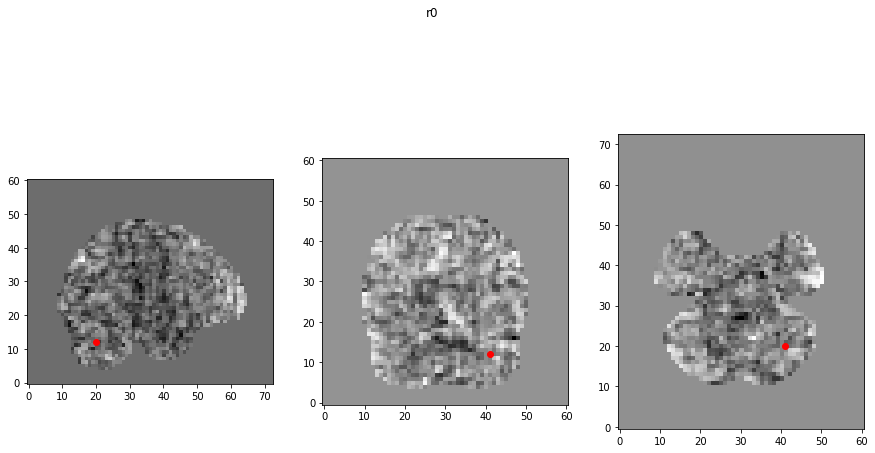

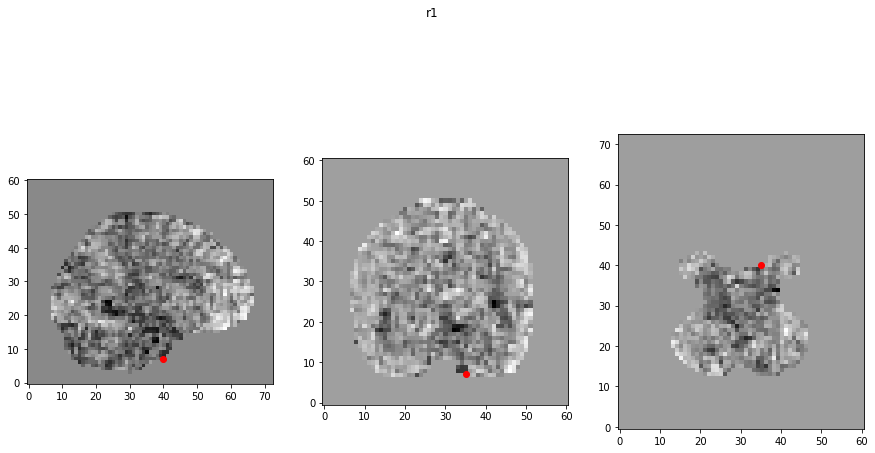

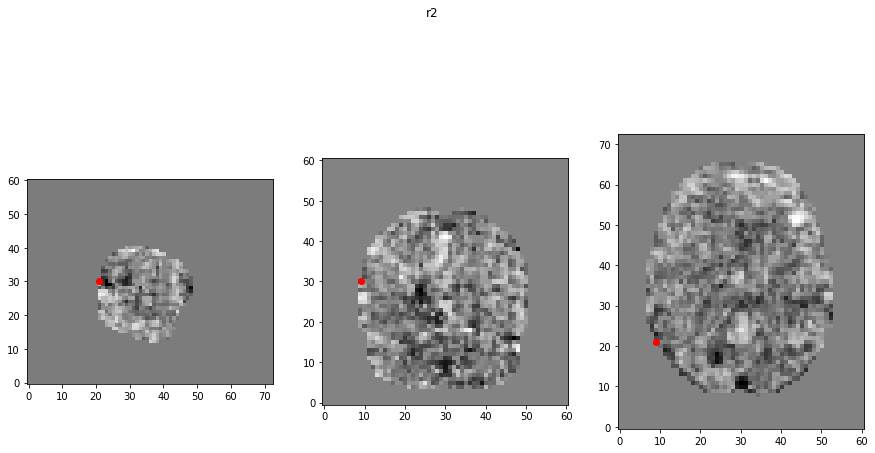

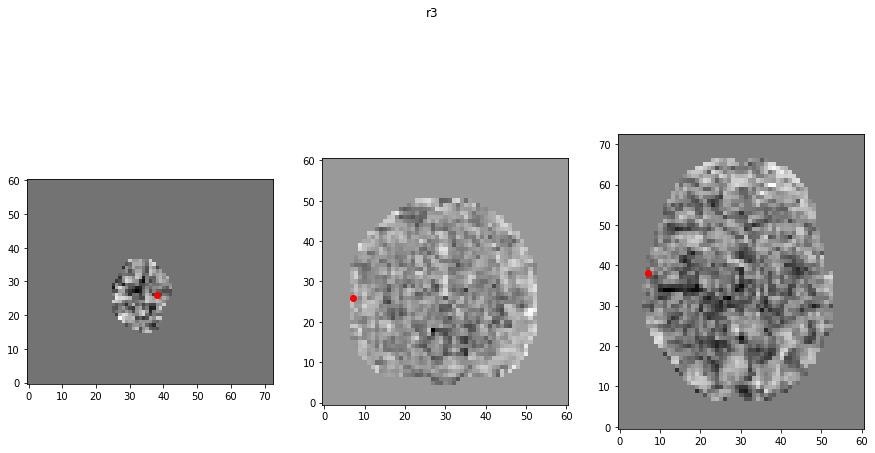

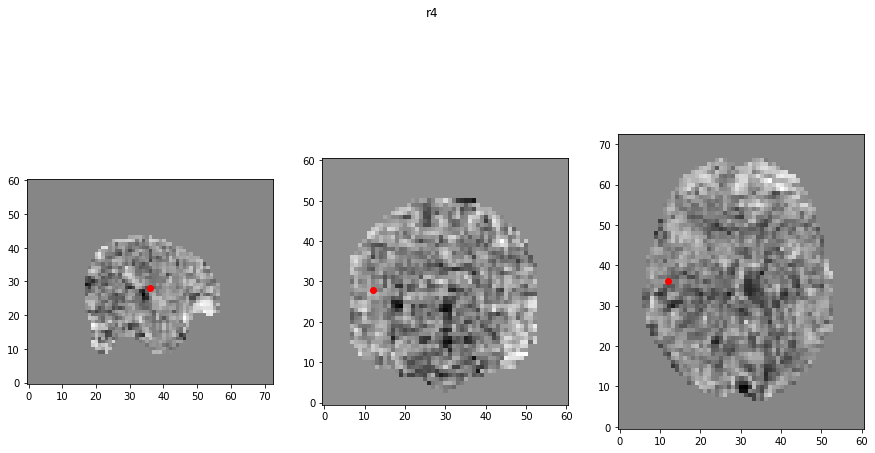

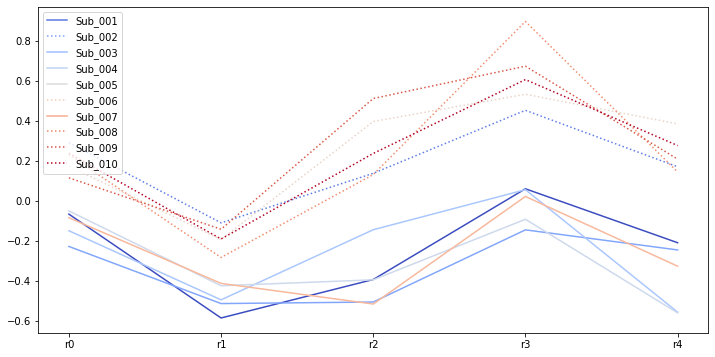

In [83]:
voi_display('fALFF_FunImgWC')

### Degree Centrality

zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_001.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_002.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_003.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_004.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_005.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_006.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_007.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_008.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_009.nii
zDegreeCentrality_PositiveBinarizedSumBrainMap_Sub_010.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_001.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_002.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_003.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_004.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_005.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_006.nii
zDegreeCentrality_PositiveWeightedSumBrainMap_Sub_007.nii
zDeg

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:147: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


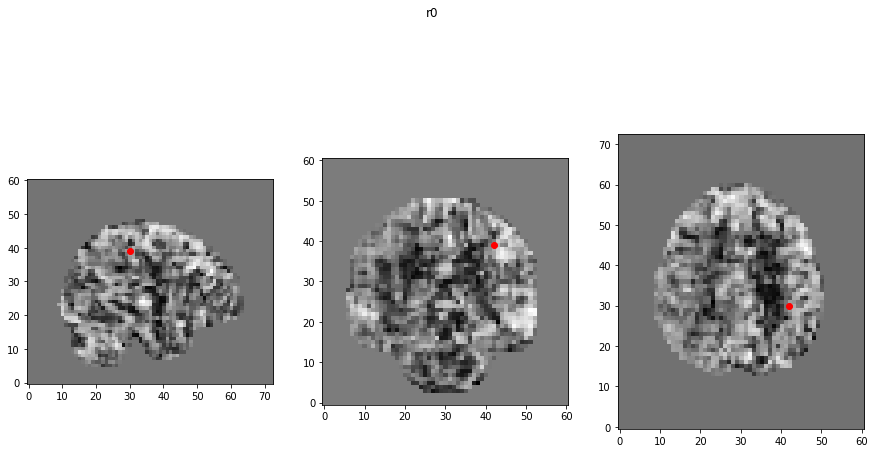

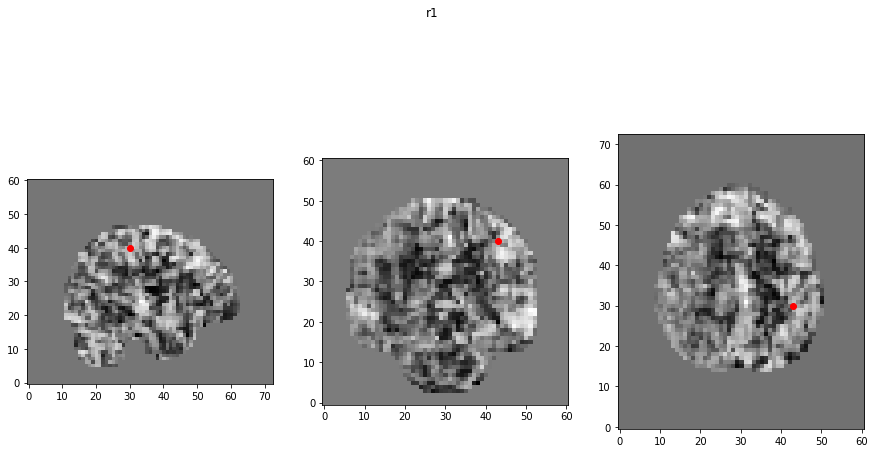

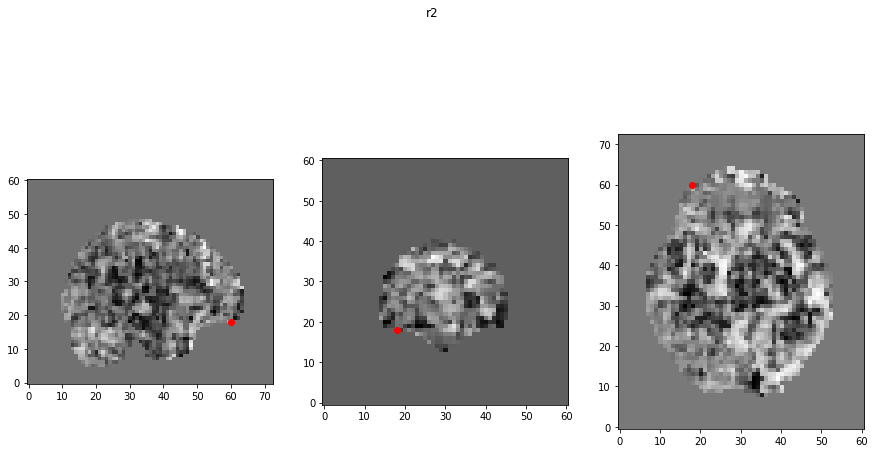

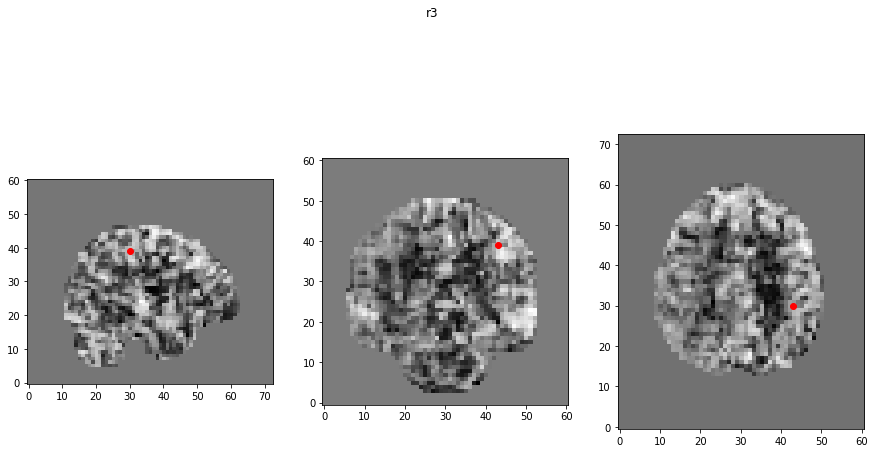

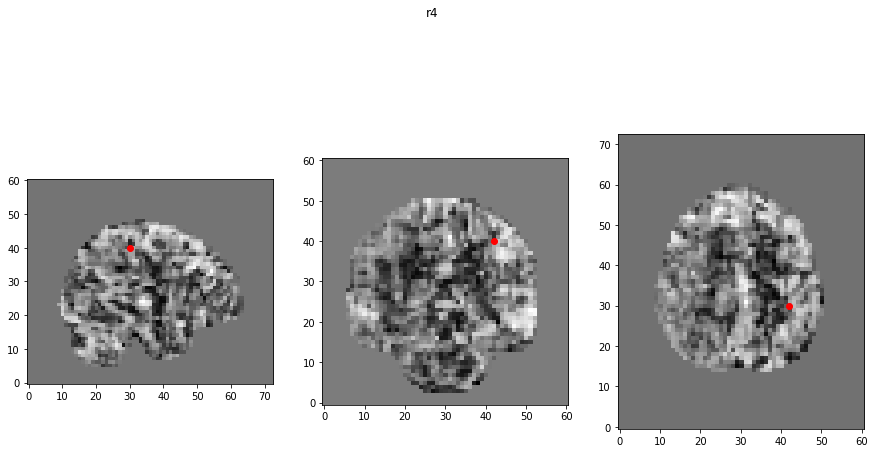

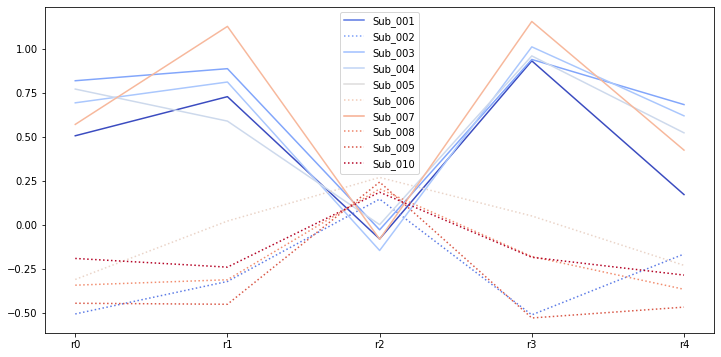

In [84]:
voi_display('DegreeCentrality_FunImgWCF')

### ReHo

zReHoMap_Sub_001.nii
zReHoMap_Sub_002.nii
zReHoMap_Sub_003.nii
zReHoMap_Sub_004.nii
zReHoMap_Sub_005.nii
zReHoMap_Sub_006.nii
zReHoMap_Sub_007.nii
zReHoMap_Sub_008.nii
zReHoMap_Sub_009.nii
zReHoMap_Sub_010.nii
    Sub_001   Sub_002   Sub_003   Sub_004   Sub_005   Sub_006   Sub_007  \
0  0.060394  0.274640  0.434714  0.530545  0.128552  0.023111 -0.232742   
1 -0.182159  0.481561  0.168044  0.444237  0.160346  0.277437 -0.447629   
2 -0.218977  0.304170 -0.125015  0.036708  0.200337  0.421658 -0.650393   
3  0.072487 -0.071823 -0.164444 -0.200386  0.187206  0.493758 -0.533357   
4  0.275256 -0.476076 -0.276619 -0.239447  0.019386  0.580865 -0.320342   

    Sub_008   Sub_009   Sub_010          pos  
0  0.866294  1.007673  0.423534  (6, 29, 21)  
1  1.321678  0.901013  0.688741  (6, 29, 22)  
2  1.470379  0.653842  0.680133  (6, 29, 23)  
3  1.451996  0.631381  0.423290  (6, 29, 24)  
4  1.308529  0.830873  0.017998  (6, 29, 25)  
voi: [((38, 19, 31), 7.956213513047431e-05), ((43, 59, 26

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:147: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


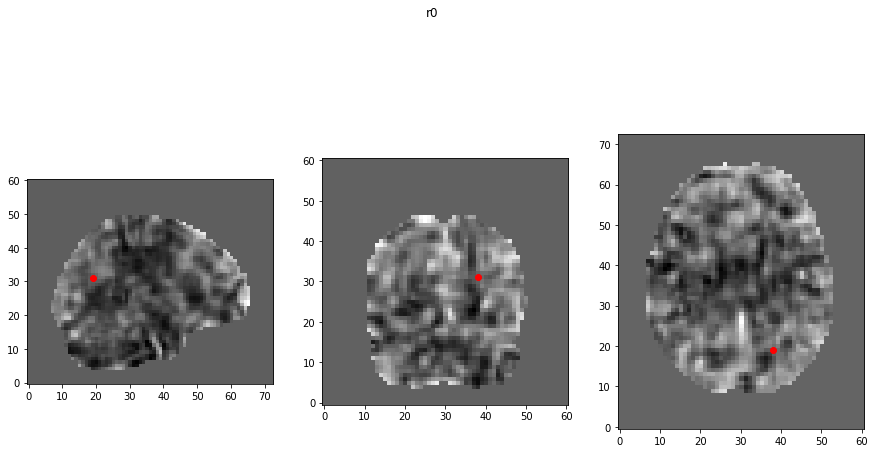

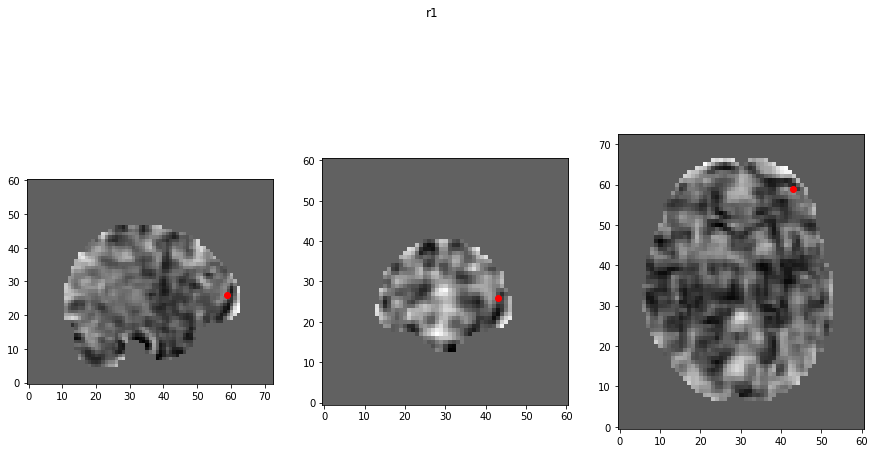

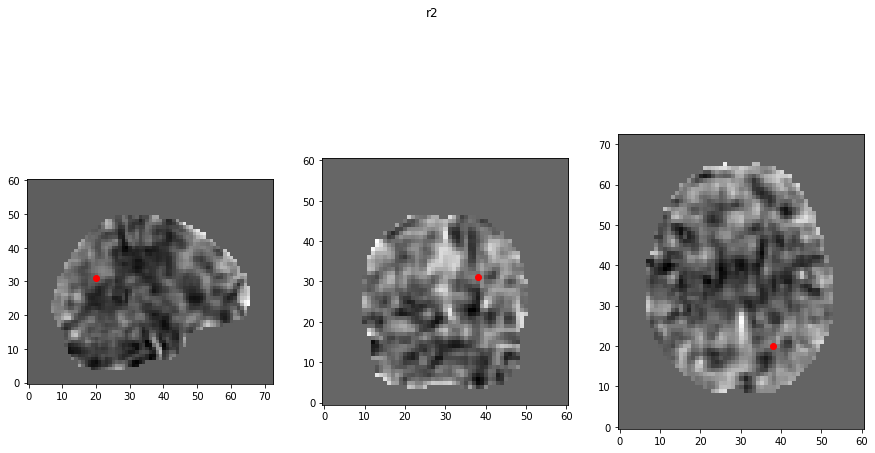

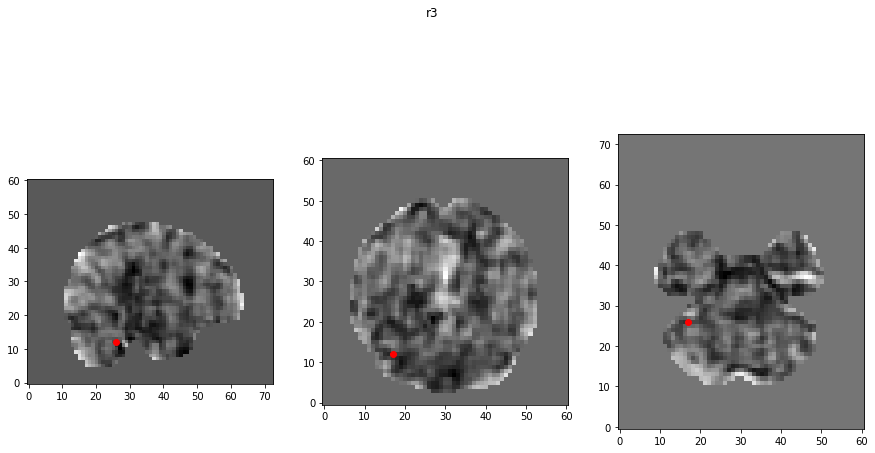

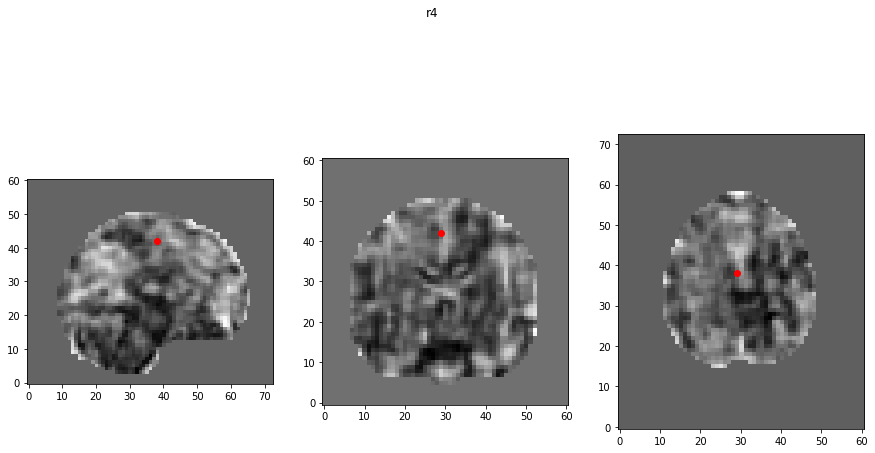

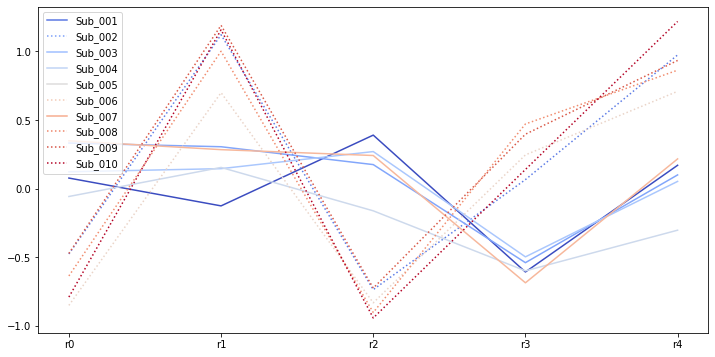

In [85]:
voi_display('ReHo_FunImgWCF')

# Classification using SVM

In [86]:
from sklearn import svm

In [87]:
subjects = ['Sub_001','Sub_002','Sub_003','Sub_004','Sub_005','Sub_006','Sub_007','Sub_008','Sub_009','Sub_010',]
# 0: CN, 1: Dementia
group = [0, 1, 0, 0, 0, 1, 0, 1, 1, 1]

In [97]:
feature_vectors.shape

# [
#     sub_001:[feature0, feature1, feature2, ...],
#     sub_002:[feature0, feature1, feature2, ...],
#     ...
#     sub_010:[feature0, feature1, feature2, ...],
# ]

(10, 20)

## linear kernel

In [101]:
# fit the model, don't regularize for illustration purposes

confusion_matrix = [            #             Actual(1) Actual(0)
                    [0, 0],     # Predict(1) [TP,       FP]
                    [0, 0]      # Predict(0) [FN,       TN]
                   ]

for i, subject in enumerate(subjects):
    X = []
    y = []
    for s in range(10):
        if s == i:
            continue
        X.append(feature_vectors[s])
        y.append(group[s])
    clf = svm.SVC(kernel='linear', C=1000)
    clf.fit(X, y)
    
    pred = feature_vectors[i].reshape(1, len(feature_vectors[i]))
    res = clf.predict(pred)[0]
    if res == 1:
        if group[i] == 1:
            confusion_matrix[0][0] += 1
        else:
            confusion_matrix[0][1] += 1
    else: # res == 0
        if group[i] == 1:
            confusion_matrix[1][0] += 1
        else:
            confusion_matrix[1][1] += 1    

TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

print('Confusion Matrix')
print('TP:{}, FP:{},\n FN:{}, TN:{}'.format(TP, FP, FN, TN))
print('Accuracy:   ', (TP+TN) / (TP+TN+FP+FN))
print('Precision:  ', TP / (TP+FP))
print('Sensitivity:', TP / (TP+FN))
print('Specificity:',TN / (TN +FP))

Confusion Matrix
TP:5, FP:0,
 FN:0, TN:5
Accuracy:    1.0
Precision:   1.0
Sensitivity: 1.0
Specificity: 1.0


## rbf kernel

In [102]:
# fit the model, don't regularize for illustration purposes

confusion_matrix = [            #             Actual(1) Actual(0)
                    [0, 0],     # Predict(1) [TP,       FP]
                    [0, 0]      # Predict(0) [FN,       TN]
                   ]

for i, subject in enumerate(subjects):
    X = []
    y = []
    for s in range(10):
        if s == i:
            continue
        X.append(feature_vectors[s])
        y.append(group[s])
    clf = svm.SVC(kernel='rbf', C=1000)
    clf.fit(X, y)
    
    pred = feature_vectors[i].reshape(1, len(feature_vectors[i]))
    res = clf.predict(pred)[0]
    if res == 1:
        if group[i] == 1:
            confusion_matrix[0][0] += 1
        else:
            confusion_matrix[0][1] += 1
    else: # res == 0
        if group[i] == 1:
            confusion_matrix[1][0] += 1
        else:
            confusion_matrix[1][1] += 1    

TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

print('Confusion Matrix')
print('TP:{}, FP:{},\n FN:{}, TN:{}'.format(TP, FP, FN, TN))
print('Accuracy:   ', (TP+TN) / (TP+TN+FP+FN))
print('Precision:  ', TP / (TP+FP))
print('Sensitivity:', TP / (TP+FN))
print('Specificity:',TN / (TN +FP))

Confusion Matrix
TP:5, FP:0,
 FN:0, TN:5
Accuracy:    1.0
Precision:   1.0
Sensitivity: 1.0
Specificity: 1.0
